In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
from kernels import *
import pdb
import gpytorch
from itertools import product

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
train_x = torch.linspace(float(0), float(1), int(50))
one = torch.sin(train_x * (float(2) * math.pi)) + torch.randn(train_x.size()) * float(0.2)
two = torch.cos(train_x * (float(2) * math.pi)) + torch.randn(train_x.size()) * float(0.2)
train_y = torch.stack([one, two], int(-1))


In [23]:
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ZeroMean(), num_tasks=2
        )
        kernel = Diff_SE_kernel()
        kernel2 = Diff_SE_kernel()
        q, dx1, dx2 = var('q, dx1, dx2')
        # TODO test what happens with 
        #L = matrix(2, 2, (dx1, q, 0, dx1))
        # -> does it learn q as a parameter?
        #AND
        #L = matrix(2, 2, (q*dx1, q, 0, dx1))
        # -> does it learn multiple separate q?
        L = matrix(2, 2, (dx1, dx1, 0, dx1))
        R = matrix(2, 2, (dx2, 0, dx2, dx2))
        p = DiffMatrixKernel([[kernel, None], [None, kernel2]])
        self.covar_module = p.diff(left_matrix=L, right_matrix=R)
        #kernel0 = Diff_SE_kernel()
        #kernel1 = Diff_SE_kernel()
        #kernel2 = Diff_SE_kernel()
        #self.covar_module = MatrixKernel([[kernel0, None], [None, kernel2]])

    def forward(self, x):
        #pdb.set_trace()
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        #print(f"{covar_x.detach().evaluate()}")
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x, validate_args=True)


likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=2)
model = MultitaskGPModel(train_x, train_y, likelihood)

In [24]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = int(2) if smoke_test else int(20)


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=float(0.1))  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    #print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f  variance: %.3f noise: %.3f' % (
    #    i + 1, training_iter, loss.item(),
    #    model.covar_module.length.item(),
    #    model.covar_module.var.item(),
    #    model.likelihood.noise.item()
    #))
    optimizer.step()

tensor([[4.0000, 3.9975, 3.9900,  ..., 0.1010, 0.0500, 0.0000],
        [3.9975, 4.0000, 3.9975,  ..., 0.1528, 0.1010, 0.0500],
        [3.9900, 3.9975, 4.0000,  ..., 0.2054, 0.1528, 0.1010],
        ...,
        [0.1010, 0.1528, 0.2054,  ..., 1.0000, 0.9994, 0.9975],
        [0.0500, 0.1010, 0.1528,  ..., 0.9994, 1.0000, 0.9994],
        [0.0000, 0.0500, 0.1010,  ..., 0.9975, 0.9994, 1.0000]],
       grad_fn=<CatBackward>)
tensor([[4.4444, 4.4410, 4.4307,  ..., 0.2979, 0.2531, 0.2087],
        [4.4410, 4.4444, 4.4410,  ..., 0.3432, 0.2979, 0.2531],
        [4.4307, 4.4410, 4.4444,  ..., 0.3888, 0.3432, 0.2979],
        ...,
        [0.2979, 0.3432, 0.3888,  ..., 1.1111, 1.1103, 1.1077],
        [0.2531, 0.2979, 0.3432,  ..., 1.1103, 1.1111, 1.1103],
        [0.2087, 0.2531, 0.2979,  ..., 1.1077, 1.1103, 1.1111]],
       grad_fn=<CatBackward>)
tensor([[5.9410, 5.9352, 5.9178,  ..., 0.3824, 0.3485, 0.3147],
        [5.9352, 5.9410, 5.9352,  ..., 0.4165, 0.3824, 0.3485],
        [5.9178,

In [5]:
for parameter in model.named_parameters():
    print(parameter)

('likelihood.raw_task_noises', Parameter containing:
tensor([-2.0370, -2.0422], requires_grad=True))
('likelihood.raw_noise', Parameter containing:
tensor([-2.0417], requires_grad=True))
('covar_module.kernel_00.kernels.0.var', Parameter containing:
tensor(1.0074, requires_grad=True))
('covar_module.kernel_00.kernels.0.length', Parameter containing:
tensor(0.5796, requires_grad=True))
('covar_module.kernel_00.kernels.1.var', Parameter containing:
tensor(1.0074, requires_grad=True))
('covar_module.kernel_00.kernels.1.length', Parameter containing:
tensor(0.5796, requires_grad=True))
('covar_module.kernel_00.kernels.2.var', Parameter containing:
tensor(1.0074, requires_grad=True))
('covar_module.kernel_00.kernels.2.length', Parameter containing:
tensor(0.5796, requires_grad=True))
('covar_module.kernel_00.kernels.3.var', Parameter containing:
tensor(1.0074, requires_grad=True))
('covar_module.kernel_00.kernels.3.length', Parameter containing:
tensor(0.5796, requires_grad=True))
('covar_m

In [6]:
# Set into eval mode
model.eval()
likelihood.eval()

# Initialize plots

number_of_samples = int(50)
# Make predictions
with torch.no_grad():#, gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(float(0), float(2), number_of_samples)
    #pdb.set_trace()
    outputs = model(test_x)
    predictions = likelihood(outputs)
    
    mean = predictions.mean
    lower, upper = predictions.confidence_region()
#print(mean)
#print(lower)
#print(upper)
# This contains predictions for both tasks, flattened out
# The first half of the predictions is for the first task
# The second half is for the second task

#dims = int(2)
#indices = [list(range(i, len(train_y), dims)) for i in range(dims)]


tensor([[11.9953, 11.9730, 11.9062,  ...,  0.2951,  0.2878,  0.2804],
        [11.9730, 11.9953, 11.9730,  ...,  0.3024,  0.2951,  0.2878],
        [11.9062, 11.9730, 11.9953,  ...,  0.3096,  0.3024,  0.2951],
        ...,
        [ 0.2951,  0.3024,  0.3096,  ...,  3.9298,  3.9214,  3.8960],
        [ 0.2878,  0.2951,  0.3024,  ...,  3.9214,  3.9298,  3.9214],
        [ 0.2804,  0.2878,  0.2951,  ...,  3.8960,  3.9214,  3.9298]])
tensor([[11.9953, 11.9730, 11.9062,  ..., -0.0551, -0.0673, -0.0790],
        [11.9730, 11.9953, 11.9730,  ..., -0.0489, -0.0613, -0.0732],
        [11.9062, 11.9730, 11.9953,  ..., -0.0425, -0.0551, -0.0673],
        ...,
        [-0.0551, -0.0489, -0.0425,  ...,  3.9298,  3.8960,  3.7955],
        [-0.0673, -0.0613, -0.0551,  ...,  3.8960,  3.9298,  3.8960],
        [-0.0790, -0.0732, -0.0673,  ...,  3.7955,  3.8960,  3.9298]])


Text(0.5, 1.0, 'Observed Values (Likelihood)')

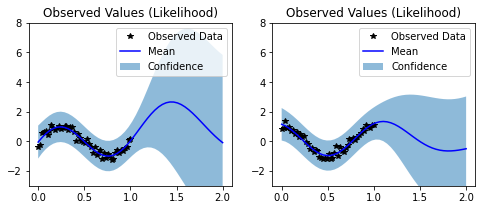

In [7]:
f, (y1_ax, y2_ax) = plt.subplots(int(1), int(2), figsize=(int(8), int(3)))

# Plot training data as black stars
y1_ax.plot(train_x.detach().numpy(), train_y[:, 0].detach().numpy(), 'k*')
# Predictive mean as blue line
y1_ax.plot(test_x.numpy(), mean[:, 0].numpy(), 'b')
# Shade in confidence
y1_ax.fill_between(test_x.numpy(), lower[:, 0].numpy(), upper[:, 0].numpy(), alpha=0.5)
y1_ax.set_ylim([-3, 8])
y1_ax.legend(['Observed Data', 'Mean', 'Confidence'])
y1_ax.set_title('Observed Values (Likelihood)')

# Plot training data as black stars
y2_ax.plot(train_x.detach().numpy(), train_y[:, 1].detach().numpy(), 'k*')
# Predictive mean as blue line
y2_ax.plot(test_x.numpy(), mean[:, 1].numpy(), 'b')
# Shade in confidence
y2_ax.fill_between(test_x.numpy(), lower[:, 1].numpy(), upper[:, 1].numpy(), alpha=0.5)
y2_ax.set_ylim([-3, 8])
y2_ax.legend(['Observed Data', 'Mean', 'Confidence'])
y2_ax.set_title('Observed Values (Likelihood)')


# Test Diffable SE Kernel

In [8]:
X = torch.tensor([int(1), int(2), int(3)])
X

tensor([1, 2, 3])

In [9]:
x1, x2, l, sigma = var('x1, x2, l, sigma')
lengthscale = 1
variance = 1
SE(x1, x2, l, sigma) = sigma^2*exp(-(x1-x2)^2/(2*l^2))
cov_matr = [[None for i in range(len(X))] for j in range(len(X))]
for i, (v1, v2) in enumerate(product(X, X)):
    cov_matr[int(i/len(X))][int(i%len(X))] = SE.diff(x2).diff(x1)(int(v1), int(v2), lengthscale, variance)
cov_matr

[[1, 0, -3*e^(-2)], [0, 1, 0], [-3*e^(-2), 0, 1]]

In [10]:
SE.operands()

[sigma^2, e^(-1/2*(x1 - x2)^2/l^2)]

In [11]:
a = Diff_SE_kernel(var=int(variance), length=int(lengthscale))
q, dx1, dx2 = var('q, dx1, dx2')
left_poly = dx2
right_poly = dx1
diffed_kernel = a.diff(left_poly=left_poly, right_poly=right_poly, left_d_var=var('dx2'), right_d_var=var('dx1'))
diffed_kernel(X).evaluate()

tensor([[ 1.0000,  0.0000, -0.4060],
        [ 0.0000,  1.0000,  0.0000],
        [-0.4060,  0.0000,  1.0000]], grad_fn=<MulBackward0>)

In [12]:
def calc_cell_diff(L, M, R, row, col):
    len_M = M.number_of_arguments()
    temp = None
    for j in range(int(sqrt(len_M))):
        if temp == None:
            import itertools
            #M_tr = list(map(list, itertools.zip_longest(*M, fillvalue=None)))
            #[M_tr[j].diff(left_poly=L[row][k], right_poly=R.transpose()[col][j]) for k in range(L.number_of_arguments())]
            temp = L[row]*M.transpose()[j]*R.transpose()[col][j]
        else:
            temp += L[row]*M.transpose()[j]*R.transpose()[col][j]
    return temp

In [13]:
dimension = 2
length = dimension*dimension +1
L_list = [var(f'l_{i}{j}') for i in range(1, dimension+1) for j in range(1, dimension+1)]
M_list = [var(f'm_{i}{j}') for i in range(1, dimension+1) for j in range(1, dimension+1)]
R_list = [var(f'r_{i}{j}') for i in range(1, dimension+1) for j in range(1, dimension+1)]
L = matrix(dimension, dimension, L_list)
M = matrix(dimension, dimension, M_list)
R = matrix(dimension, dimension, R_list)
print(L)
print(M)
print(R)
row = 1
col = 0
print((L*M*R)[row][col])

calc_cell_diff(L, M, R, row, col)

[l_11 l_12]
[l_21 l_22]
[m_11 m_12]
[m_21 m_22]
[r_11 r_12]
[r_21 r_22]
(l_21*m_11 + l_22*m_21)*r_11 + (l_21*m_12 + l_22*m_22)*r_21


(l_21*m_11 + l_22*m_21)*r_11 + (l_21*m_12 + l_22*m_22)*r_21

In [14]:
from itertools import product
for p in product(L.rows(),R.columns()):
    print(p)

((l_11, l_12), (r_11, r_21))
((l_11, l_12), (r_12, r_22))
((l_21, l_22), (r_11, r_21))
((l_21, l_22), (r_12, r_22))


In [15]:
MSE(x1, x2, sigma, l) = matrix(2,2, (sigma^2*exp(-(x1-x2)^2/(2*l^2)), 0, 0, sigma^2*exp(-(x1-x2)^2/(2*l^2))))
dx1 = matrix(2,2,(dx1, 0, 0, dx1))
MSE

(x1, x2, sigma, l) |--> [sigma^2*e^(-1/2*(x1 - x2)^2/l^2)                                0]
[                               0 sigma^2*e^(-1/2*(x1 - x2)^2/l^2)]

In [16]:
kernel = Diff_SE_kernel()
kernel3 = Diff_SE_kernel()
kernel2 = Diff_SE_kernel()

l = [[kernel, kernel3], [kernel3, kernel2]]
l

[[Diff_SE_kernel(), Diff_SE_kernel()], [Diff_SE_kernel(), Diff_SE_kernel()]]

In [17]:
class testobject():
    def __init__(self, val):
        self.val = val
    
    def setVal(self, val):
        self.val = val
        
    def printVal(self):
        return self.val
    
    def __call__(self):
        return self.val

In [18]:
t1 = testobject(42)
t2 = testobject(21)
t3 = testobject(17)
l = [[t1, t2], [t2, t3]]
print(l)
t2.setVal(170)
print(l[0][1].printVal())
print(l[1][0].printVal())

[[<__main__.testobject object at 0x26513c310>, <__main__.testobject object at 0x26513c2b0>], [<__main__.testobject object at 0x26513c2b0>, <__main__.testobject object at 0x26513c370>]]
170
170


In [19]:
q, dx1, dx2 = var('q, dx1, dx2')
left_poly = dx1
right_poly = dx2
L = matrix(2, 2, (dx1, 0, 0, dx1))
R = matrix(2, 2, (dx2, 0, 0, dx2))

In [20]:
p.diff(left_matrix=L, right_matrix=R).forward(X, X)

AttributeError: 'tuple' object has no attribute 'diff'

In [ ]:
w, q, dx1, dx2 = var('w, q, dx1, dx2')
a = dx1^2
#a.degree(dx1)
a.operands()

In [ ]:
prod([1,2,3])

In [27]:
a = torch.Tensor([[int(1), int(2), int(3)], [int(4), int(5), int(6)], [int(7), int(8), int(9)]])
for i, row in enumerate(a):
    for j, elem in enumerate(row[i:]):
        print(f"row: {i}, col: {i+j}")
        print(elem)

row: 0, col: 0
tensor(1.)
row: 0, col: 1
tensor(2.)
row: 0, col: 2
tensor(3.)
row: 1, col: 1
tensor(5.)
row: 1, col: 2
tensor(6.)
row: 2, col: 2
tensor(9.)
